In [1]:
import os
import numpy as np
import time
import pickle
import imp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt


from cruw import CRUW
from rodnet.datasets.CRDataset import CRDataset
from rodnet.datasets.collate_functions import cr_collate
from rodnet.utils.solve_dir import create_dir_for_new_model
from rodnet.utils.load_configs import load_configs_from_file, parse_cfgs, update_config_dict
from rodnet.utils.visualization import visualize_train_img, visualize_test_img_wo_gt, visualize_confmap, visualize_test_img
from rodnet.core.post_processing import ConfmapStack, post_process, post_process_single_frame, write_dets_results, write_dets_results_single_frame, lnms, ops

/var/folders/lj/_chmmmhd2m5328svknqdk8b80000gn/T/ipykernel_99171/670376179.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<Figure size 800x800 with 0 Axes>

In [ ]:
import getModel
imp.reload(getModel)
from getModel import ROD_V0, ROD_V1, ROD_V2
import trainModel
imp.reload(trainModel)
from trainModel import modelHandler,baseHandler

In [2]:
config_dict = load_configs_from_file('/Users/kushalgadhiya/Desktop/Winter2024/ENDG 511/Project/RODNet-master/configs/config_rodnet_cdc_win16.py')
dataset = CRUW(data_root=config_dict['dataset_cfg']['base_root'], sensor_config_name='sensor_config_rod2021')
radar_configs = dataset.sensor_cfg.radar_cfg
range_grid = dataset.range_grid         
angle_grid = dataset.angle_grid         
model_cfg = config_dict['model_cfg']

In [8]:
crdata_train = CRDataset(data_dir='/Volumes/T7MAC/data_v3', dataset=dataset, config_dict=config_dict, split='train',
                                 noise_channel= False)
print(len(crdata_train))

100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

12202


In [6]:
n_class = dataset.object_cfg.n_class          
n_epoch = config_dict['train_cfg']['n_epoch']   
batch_size = config_dict['train_cfg']['batch_size'] 
lr = config_dict['train_cfg']['lr']
train_configs = config_dict['train_cfg']
test_configs = config_dict['test_cfg']
win_size = train_configs['win_size']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
testdata, valdata = torch.utils.data.random_split(crdata_train,[10000,2202])

In [10]:
tdataloader = DataLoader(testdata, batch_size, shuffle=True, num_workers=0, collate_fn=cr_collate)
vdataloader = DataLoader(valdata, batch_size =1, shuffle=True, num_workers=0, collate_fn=cr_collate)

In [12]:
train_model_path_multi_1 = '/Volumes/T7MAC/trainedrepo/multi_1'         #entre your desired location to store trained model
if not os.path.exists(train_model_path_multi_1):
    os.makedirs(train_model_path_multi_1)
train_model_path_multi_2 = '/Volumes/T7MAC/trainedrepo/multi_2'         #entre your desired location to store trained model
if not os.path.exists(train_model_path_multi_2):
    os.makedirs(train_model_path_multi_2)
test_res_dir_multi_1 = os.path.join(os.path.join('/Volumes/T7MAC/resultrepo', 'multi_1'))
if not os.path.exists(test_res_dir_multi_1):
    os.makedirs(test_res_dir_multi_1)
test_res_dir_multi_2 = os.path.join(os.path.join('/Volumes/T7MAC/resultrepo', 'multi_2'))
if not os.path.exists(test_res_dir_multi_2):
    os.makedirs(test_res_dir_multi_2)

In [ ]:
rod_v1 = ROD_V1(in_channels=2, n_class=n_class).to(device)
optimizer_v1 = optim.Adam(rod_v1.parameters(), lr=lr)
criterion_v1 = nn.BCELoss()
scheduler_v1 = StepLR(optimizer_v1, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

M_v1 = modelHandler(rod_v1,criterion_v1,optimizer_v1,device,scheduler_v1,n_epoch)

In [39]:
rod_v2 = ROD_V2(in_channels=2, n_class=n_class).to(device)
optimizer_v2 = optim.Adam(rod_v2.parameters(), lr=lr)
criterion_v2 = nn.BCELoss()
scheduler_v2 = StepLR(optimizer_v2, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

M_v2 = modelHandler(rod_v2,criterion_v2,optimizer_v2,device,scheduler_v2,n_epoch)

Number of encoder parameters: 11089728
Number of decoder short parameters: 1200453
Number of decoder long parameters: 28039110


***Train multibranch model***

epoch 1 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...
epoch 2 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...
epoch 3 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...


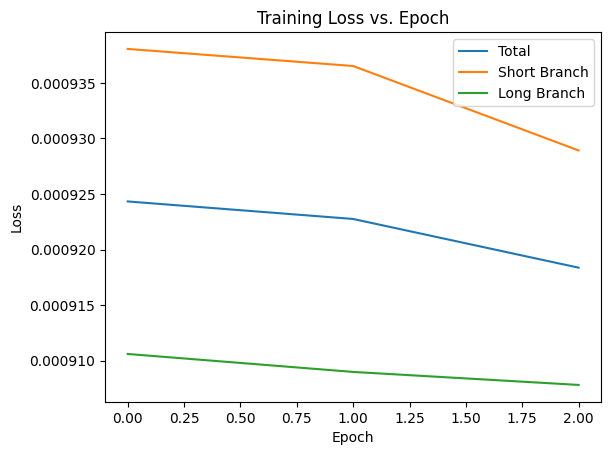

In [12]:
rodNet_v1, history_v1 = M_v1.train(tdataloader,train_model_path_multi_1)

In [ ]:
total_loss = history_v1['T']['train']['loss']
short_branch_loss = history_v1['1']['train']['loss']
long_branch_loss = history_v1['2']['train']['loss']
epochs = np.array([i for i in range(n_epoch)])
plt.plot(epochs, total_loss, label='Total')
plt.plot(epochs,short_branch_loss, label='Short Branch')
plt.plot(epochs,long_branch_loss, label='Long Branch')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
rodNet_v2, history_v2 = M_v2.train(tdataloader,train_model_path_multi_2)

epoch 1 --> shortbranchloss: 0.000, longbranchloss: 0.000, totalloss: 0.000
saving current epoch model ...
{'1': {'train': {'loss': [7.265275120735169e-05, 7.188818454742431e-05, 7.148569226264953e-05]}}, '2': {'train': {'loss': [7.010011672973633e-05, 6.994512677192688e-05, 6.979925632476807e-05]}}, 'T': {'train': {'loss': [7.1376433968544e-05, 7.09166556596756e-05, 7.06424742937088e-05]}}}


In [ ]:
total_loss = history_v2['T']['train']['loss']
short_branch_loss = history_v2['1']['train']['loss']
long_branch_loss = history_v2['2']['train']['loss']
epochs = np.array([i for i in range(n_epoch)])
plt.plot(epochs, total_loss, label='Total')
plt.plot(epochs,short_branch_loss, label='Short Branch')
plt.plot(epochs,long_branch_loss, label='Long Branch')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluation**

In [12]:
from cruw.eval import evaluate_rodnet_seq
from cruw.eval.rod.rod_eval_utils import accumulate, summarize
from cruw.eval.rod.load_txt import read_gt_txt, read_sub_txt, read_rodnet_res
from cruw.eval.rod.rod_eval_utils import compute_ols_dts_gts, evaluate_img, accumulate, summarize

In [40]:
rod_v1 = ROD_V1(in_channels=2, n_class=n_class).to(device)
rod_v1.load_state_dict(torch.load(os.path.join(train_model_path_multi_1,'multi_epoch_0{}_final.pkl'.format(n_epoch)), map_location=torch.device('cpu')))
rod_v1.eval()
val_loss_class_0_short = []
val_loss_class_1_short = []
val_loss_class_2_short = []
val_loss_class_0_long = []
val_loss_class_1_long = []
val_loss_class_2_long = []
early_exit_count = 0
ols_ans_1 = []
ols_ans_2 = []
early_exit_count = 0
total_ped, total_cyc, total_car = 0,0,0

with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        if seq_name == '2019_09_29_ONRD006':
            continue
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_preds_1,confmap_preds_2 = rod_v1(data.float())
        loss_1_class0, loss_2_class0 = criterion_v1(confmap_preds_1[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()), criterion_v1(confmap_preds_2[:,0,:,:,:], confmap_gt[:,0,:,:,:].float())
        loss_1_class1, loss_2_class1 = criterion_v1(confmap_preds_1[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()), criterion_v1(confmap_preds_2[:,1,:,:,:], confmap_gt[:,1,:,:,:].float())
        loss_1_class2, loss_2_class2 = criterion_v1(confmap_preds_1[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()), criterion_v1(confmap_preds_2[:,2,:,:,:], confmap_gt[:,2,:,:,:].float())
        val_loss_class_0_short.append(loss_1_class0)
        val_loss_class_1_short.append(loss_1_class1)
        val_loss_class_2_short.append(loss_1_class2)
        val_loss_class_0_long.append(loss_2_class0)
        val_loss_class_1_long.append(loss_2_class1)
        val_loss_class_2_long.append(loss_2_class2)

        pred1 = confmap_preds_1[0,:,0,:,:]
        pred2 = confmap_preds_2[0,:,0,:,:]

        result1 = post_process_single_frame(pred1, dataset, config_dict)
        result2 = post_process_single_frame(pred2, dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_multi_1, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f1 = open(os.path.join(seq_res_dir, 'rod_res_1.txt'), 'a')
        f2 = open(os.path.join(seq_res_dir, 'rod_res_2.txt'), 'a')
        f1.close()
        f2.close()
        save_path_1 = os.path.join(test_res_dir_multi_1, seq_name, 'rod_res_1.txt')
        save_path_2 = os.path.join(test_res_dir_multi_1, seq_name, 'rod_res_2.txt')

        write_dets_results_single_frame(result1, start_frame, save_path_1, dataset)
        write_dets_results_single_frame(result2, start_frame, save_path_2, dataset)
        
        gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        if gt_dets[start_frame,0] == None and gt_dets[start_frame,1] == None and gt_dets[start_frame,2] == None:
            continue
        sub_dets_1 = read_rodnet_res(save_path_1, n_frame, dataset)
        sub_dets_2 = read_rodnet_res(save_path_2, n_frame, dataset)
        olss_all_1 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_1, start_frame, catId, dataset) \
                    for catId in range(3)}
        olss_all_2 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_2, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans_1.append(olss_all_1)
        ols_ans_1.append(olss_all_2)
        
        if(len(gt_dets[start_frame,0]) == len(sub_dets_1[start_frame,0]) and len(gt_dets[start_frame,1]) == len(sub_dets_1[start_frame,1]) and len(gt_dets[start_frame,2]) == len(sub_dets_1[start_frame,2])):
            total_ped += total_ped+len(sub_dets_1[start_frame,0])
            total_cyc += total_cyc+len(sub_dets_1[start_frame,1])
            total_car += total_car+len(sub_dets_1[start_frame,2])
            early_exit_count += 1
        
    print("Number of samples will exit early {}".format(early_exit_count))
    print(f"Number of pedestrian {total_ped}")
    print(f"Number of cyclist {total_ped}")
    print(f"Number of car {total_car}")

Number of encoder parameters: 6481152
Number of decoder short parameters: 1200453
Number of decoder long parameters: 28039110


RuntimeError: Error(s) in loading state_dict for ROD_V1:
	Unexpected key(s) in state_dict: "encoder_base.12.weight", "encoder_base.12.bias", "encoder_base.13.weight", "encoder_base.13.bias", "encoder_base.13.running_mean", "encoder_base.13.running_var", "encoder_base.13.num_batches_tracked", "encoder_base.15.weight", "encoder_base.15.bias", "encoder_base.16.weight", "encoder_base.16.bias", "encoder_base.16.running_mean", "encoder_base.16.running_var", "encoder_base.16.num_batches_tracked". 
	size mismatch for encoder_base.6.weight: copying a param with shape torch.Size([64, 64, 9, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 64, 9, 5, 5]).
	size mismatch for encoder_base.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder_base.7.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder_base.7.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder_base.7.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder_base.7.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder_base.9.weight: copying a param with shape torch.Size([128, 64, 9, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 9, 5, 5]).

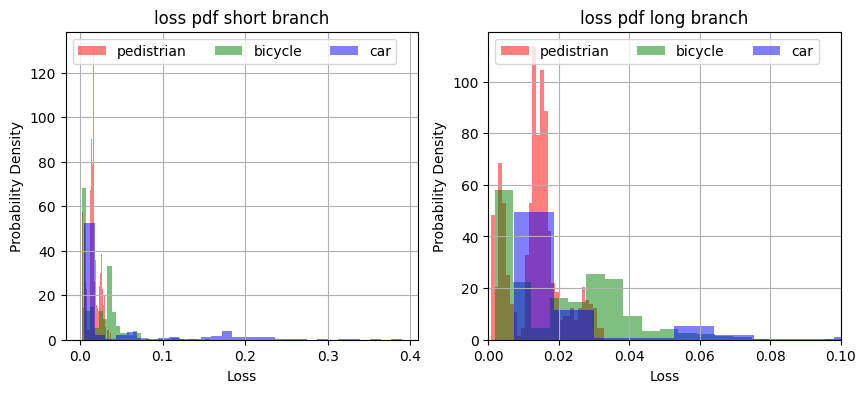

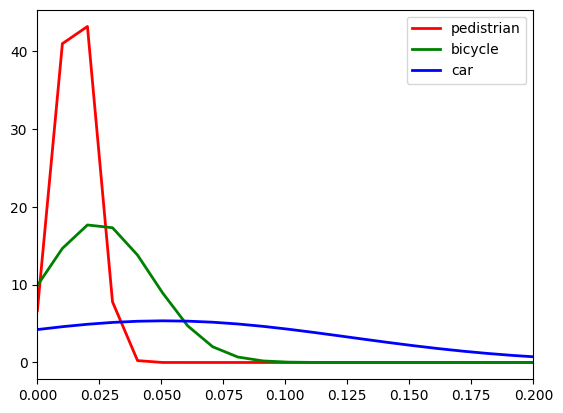

In [77]:
from scipy.stats import norm
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(np.round(np.array(val_loss_class_0_short),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_short),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_short),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf short branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(np.round(np.array(val_loss_class_0_long),8), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_long),8), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_long),8), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf long branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.xlim([0,0.1])
plt.show()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, loc=np.mean(val_loss_class_0_short), scale=np.std(val_loss_class_0_short))
p1 = norm.pdf(x, loc=np.mean(val_loss_class_1_short), scale=np.std(val_loss_class_1_short))
p2 = norm.pdf(x, loc=np.mean(val_loss_class_2_short), scale=np.std(val_loss_class_2_short))
plt.plot(x, p, linewidth=2, label = 'pedistrian', color = 'red')
plt.plot(x, p1, linewidth=2, label = 'bicycle', color = 'green')
plt.plot(x, p2, linewidth=2, label = 'car', color = 'blue')
plt.xlim([0,0.2])
plt.legend()

In [ ]:
rod_v2 = ROD_V2(in_channels=2, n_class=n_class).to(device)
rod_v2.load_state_dict(torch.load(os.path.join(train_model_path_multi_2,'multi_epoch_0{}_final.pkl'.format(n_epoch)), map_location=torch.device('cpu')))
rod_v2.eval()
val_loss_class_0_short = []
val_loss_class_1_short = []
val_loss_class_2_short = []
val_loss_class_0_long = []
val_loss_class_1_long = []
val_loss_class_2_long = []
early_exit_count = 0
ols_ans_1 = []
ols_ans_2 = []
early_exit_count = 0
total_ped, total_cyc, total_car = 0,0,0

with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        if seq_name == '2019_09_29_ONRD006':
            continue
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_preds_1,confmap_preds_2 = rod_v2(data.float())
        loss_1_class0, loss_2_class0 = criterion_v2(confmap_preds_1[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()), criterion_v2(confmap_preds_2[:,0,:,:,:], confmap_gt[:,0,:,:,:].float())
        loss_1_class1, loss_2_class1 = criterion_v2(confmap_preds_1[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()), criterion_v2(confmap_preds_2[:,1,:,:,:], confmap_gt[:,1,:,:,:].float())
        loss_1_class2, loss_2_class2 = criterion_v2(confmap_preds_1[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()), criterion_v2(confmap_preds_2[:,2,:,:,:], confmap_gt[:,2,:,:,:].float())
        val_loss_class_0_short.append(loss_1_class0)
        val_loss_class_1_short.append(loss_1_class1)
        val_loss_class_2_short.append(loss_1_class2)
        val_loss_class_0_long.append(loss_2_class0)
        val_loss_class_1_long.append(loss_2_class1)
        val_loss_class_2_long.append(loss_2_class2)

        pred1 = confmap_preds_1[0,:,0,:,:]
        pred2 = confmap_preds_2[0,:,0,:,:]

        result1 = post_process_single_frame(pred1, dataset, config_dict)
        result2 = post_process_single_frame(pred2, dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_multi_2, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f1 = open(os.path.join(seq_res_dir, 'rod_res_1.txt'), 'a')
        f2 = open(os.path.join(seq_res_dir, 'rod_res_2.txt'), 'a')
        f1.close()
        f2.close()
        save_path_1 = os.path.join(test_res_dir_multi_2, seq_name, 'rod_res_1.txt')
        save_path_2 = os.path.join(test_res_dir_multi_2, seq_name, 'rod_res_2.txt')

        write_dets_results_single_frame(result1, start_frame, save_path_1, dataset)
        write_dets_results_single_frame(result2, start_frame, save_path_2, dataset)
        
        gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        if gt_dets[start_frame,0] == None and gt_dets[start_frame,1] == None and gt_dets[start_frame,2] == None:
            continue
        sub_dets_1 = read_rodnet_res(save_path_1, n_frame, dataset)
        sub_dets_2 = read_rodnet_res(save_path_2, n_frame, dataset)
        olss_all_1 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_1, start_frame, catId, dataset) \
                    for catId in range(3)}
        olss_all_2 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_2, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans_1.append(olss_all_1)
        ols_ans_1.append(olss_all_2)
        
        if(len(gt_dets[start_frame,0]) == len(sub_dets_1[start_frame,0]) and len(gt_dets[start_frame,1]) == len(sub_dets_1[start_frame,1]) and len(gt_dets[start_frame,2]) == len(sub_dets_1[start_frame,2])):
            total_ped += total_ped+len(sub_dets_1[start_frame,0])
            total_cyc += total_cyc+len(sub_dets_1[start_frame,1])
            total_car += total_car+len(sub_dets_1[start_frame,2])
            early_exit_count += 1
        
    print("Number of samples will exit early {}".format(early_exit_count))
    print(f"Number of pedestrian {total_ped}")
    print(f"Number of cyclist {total_ped}")
    print(f"Number of car {total_car}")

In [251]:
olsThrs = np.around(np.linspace(0.5, 0.9, int(np.round((0.9 - 0.5) / 0.05) + 1), endpoint=True), decimals=2)
recThrs = np.around(np.linspace(0.0, 1.0, int(np.round((1.0 - 0.0) / 0.01) + 1), endpoint=True), decimals=2)
seq_names = sorted(os.listdir('/Volumes/T7MAC/resultrepo/multi_1'))
seq_names = [name for name in seq_names if '.' not in name]

evalImgs_all = []
n_frames_all = 0

for seq_name in seq_names:
    gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
    res_path = os.path.join('/Volumes/T7MAC/resultrepo/multi_1', seq_name, 'rod_res.txt')

    data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
    n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
    evalImgs = evaluate_rodnet_seq(res_path, gt_path, n_frame, dataset)
    eval = accumulate(evalImgs, n_frame, olsThrs, recThrs, dataset, log=False)
    stats = summarize(eval, olsThrs, recThrs, dataset, gl=False)
    print("%s | AP_total: %.4f | AR_total: %.4f" % (seq_name.upper(), stats[0] * 100, stats[1] * 100))

    n_frames_all += n_frame
    evalImgs_all.extend(evalImgs)

eval = accumulate(evalImgs_all, n_frames_all, olsThrs, recThrs, dataset, log=False)
stats = summarize(eval, olsThrs, recThrs, dataset, gl=False)
print("%s | AP_total: %.4f | AR_total: %.4f" % ('Overall'.ljust(18), stats[0] * 100, stats[1] * 100))

2019_04_30_MLMS000 | AP_total: 0.3534 | AR_total: 0.8026
2019_04_30_PCMS001 | AP_total: 0.3030 | AR_total: 0.5683
2019_04_30_PM2S004 | AP_total: 0.8251 | AR_total: 0.2650
2019_05_29_PBMS007 | AP_total: 1.3740 | AR_total: 1.4753
2019_09_29_ONRD002 | AP_total: 2.0736 | AR_total: 2.6437
Overall            | AP_total: 0.4248 | AR_total: 1.2436


In [ ]:
olsThrs = np.around(np.linspace(0.5, 0.9, int(np.round((0.9 - 0.5) / 0.05) + 1), endpoint=True), decimals=2)
recThrs = np.around(np.linspace(0.0, 1.0, int(np.round((1.0 - 0.0) / 0.01) + 1), endpoint=True), decimals=2)
seq_names = sorted(os.listdir('/Volumes/T7MAC/resultrepo/multi_2'))
seq_names = [name for name in seq_names if '.' not in name]

evalImgs_all = []
n_frames_all = 0

for seq_name in seq_names:
    gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
    res_path = os.path.join('/Volumes/T7MAC/resultrepo/multi_2', seq_name, 'rod_res.txt')

    data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
    n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
    evalImgs = evaluate_rodnet_seq(res_path, gt_path, n_frame, dataset)
    eval = accumulate(evalImgs, n_frame, olsThrs, recThrs, dataset, log=False)
    stats = summarize(eval, olsThrs, recThrs, dataset, gl=False)
    print("%s | AP_total: %.4f | AR_total: %.4f" % (seq_name.upper(), stats[0] * 100, stats[1] * 100))

    n_frames_all += n_frame
    evalImgs_all.extend(evalImgs)

eval = accumulate(evalImgs_all, n_frames_all, olsThrs, recThrs, dataset, log=False)
stats = summarize(eval, olsThrs, recThrs, dataset, gl=False)
print("%s | AP_total: %.4f | AR_total: %.4f" % ('Overall'.ljust(18), stats[0] * 100, stats[1] * 100))